# Import libraries

In [1]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
import sklearn.model_selection as skm

## Exploring the data

In [3]:
IMG_SIZE=(80,80)
channels=1
path="./faces"

In [4]:
char_dict = {}
for char in os.listdir(path):
    char_dict[char] = len(os.listdir(os.path.join(path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('Neymar', 174),
 ('Marquinhos', 153),
 ('Navas', 147),
 ('Verratti', 144),
 ('Mbappe', 139)]

In [5]:
#  Getting the categories of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 5:
        break
characters

['Neymar', 'Marquinhos', 'Navas', 'Verratti', 'Mbappe']

<br><br><br>
# PSG Players face recognition with TensorFlow

## Preprocessing

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models as KM
from tensorflow.keras import layers as KL
from tensorflow.keras import backend as K
import glob

In [24]:
IMG_DIMS = (64, 64, 3)
LR = 0.001
EPOCHS = 75
BATCHSIZE = 128

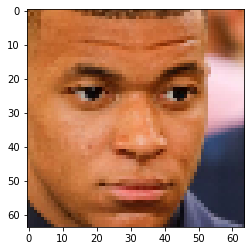

In [25]:
a = cv2.imread("./faces/Mbappe/1.jpg")
a = cv2.resize(a, IMG_DIMS[:2])
plt.imshow(a)

In [26]:
project_path = os.getcwd()

In [89]:
def train_test_creation(dataset_size = 100):

  assert dataset_size >= 1
  
  all_imgs = []
  labels = []
  players = ('Marquinhos','Mbappe','Navas','Neymar','Verratti')

  print('Creation of the dataset...')
  #Append image and their corresponding label in lists
  for player in players:

    for img in os.listdir('./faces/'+player):
      try:
        current = cv2.imread(os.path.join(f"./faces/{player}/{img}"))
        current = cv2.resize(current, IMG_DIMS[:2])
        all_imgs.append(img_to_array(current))

        
        
        if player == "Marquinhos" : 
            labels.append(0)
        elif player == "Mbappe" :
                labels.append(1)
        elif player == "Navas" :
                labels.append(2)
        elif player == "Neymar" :
                labels.append(3)
        else :

            labels.append(4)        
      except:
        pass
    print(f'All {player} pictures have been added.')
  print('')

  print('Normalizing features...')
  #Convert image array to float and normalize it
  all_imgs = np.array(all_imgs, dtype="float")
  all_imgs /= 255.0

  print('Dealing with labels...')
  #Resize labels list shape to fit with all_imgs shape
  labels = np.array(labels)
  labels = labels.reshape(-1, 1)
  labels = to_categorical(labels, num_classes=5)

  X_train, X_test, y_train, y_test = train_test_split(all_imgs, labels, train_size=0.75, 
                                                      shuffle=True, random_state=10)

  return X_train, X_test, y_train, y_test

In [92]:
X_train, X_test, y_train, y_test =train_test_creation(140)

Creation of the dataset...
All Marquinhos pictures have been added.
All Mbappe pictures have been added.
All Navas pictures have been added.
All Neymar pictures have been added.
All Verratti pictures have been added.

Normalizing features...
Dealing with labels...


In [93]:
X_train.shape

(567, 64, 64, 3)

In [94]:
datagen = ImageDataGenerator(rotation_range=0.2, height_shift_range=0.05, width_shift_range=0.05, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest")
datagen.fit(X_train)

## Model conception

In [100]:
def build_model(height, width, channel):
  #Check the position of channels in Keras backend
  if K.image_data_format() == "channels_last":
    channel_axis = -1
    input_shape = (height, width, channel)
  
  else :
    channel_axis = 1 # First axis is batch_size
    input_shape = (channel, height, width)

  model = KM.Sequential()

  model.add(KL.Conv2D(filters=32, kernel_size=5, padding='same', kernel_initializer="he_uniform", input_shape=input_shape))
  model.add(KL.BatchNormalization(axis=channel_axis))
  model.add(KL.Activation("relu"))
  model.add(KL.MaxPool2D(pool_size=2, strides=2, padding="same"))
  model.add(KL.Dropout(0.3))

  model.add(KL.Conv2D(filters=64, kernel_size=5, padding='same', kernel_initializer="he_uniform"))
  model.add(KL.BatchNormalization(axis=channel_axis))
  model.add(KL.Activation("relu"))
  model.add(KL.MaxPool2D(pool_size=2, strides=2, padding="same"))
  model.add(KL.Dropout(0.3))
  
  
  model.add(KL.Flatten())
  model.add(KL.Dense(512, kernel_initializer="he_uniform", kernel_regularizer=l2(0.0001)))
  model.add(KL.BatchNormalization())
  model.add(KL.Activation("relu"))
  model.add(KL.Dropout(0.5))

  model.add(KL.Dense(5))
  model.add(KL.Activation("softmax"))

  return model

In [101]:
model = build_model(*IMG_DIMS)

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)       

In [103]:

opt = Adam(learning_rate=LR, decay=LR/EPOCHS)
#opt_sgd = SGD(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics="accuracy") 


In [104]:

#FITTING WITH DATA IMAGE GENERATOR

hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCHSIZE), validation_data=(X_test, y_test),
          epochs = EPOCHS, steps_per_epoch=(X_train.shape[0]//BATCHSIZE), verbose=1)

Epoch 1/75
4/4 [==============================] - 4s 866ms/step - loss: 2.3787 - accuracy: 0.2969 - val_loss: 2.9466 - val_accuracy: 0.2579
Epoch 2/75
4/4 [==============================] - 3s 689ms/step - loss: 1.6498 - accuracy: 0.4989 - val_loss: 4.2194 - val_accuracy: 0.2895
Epoch 3/75
4/4 [==============================] - 3s 702ms/step - loss: 1.3661 - accuracy: 0.5581 - val_loss: 5.9458 - val_accuracy: 0.2474
Epoch 4/75
4/4 [==============================] - 3s 740ms/step - loss: 1.4386 - accuracy: 0.5604 - val_loss: 3.8925 - val_accuracy: 0.2684
Epoch 5/75
4/4 [==============================] - 3s 715ms/step - loss: 1.1428 - accuracy: 0.6424 - val_loss: 1.7608 - val_accuracy: 0.4368
Epoch 6/75
4/4 [==============================] - 3s 761ms/step - loss: 1.1789 - accuracy: 0.6378 - val_loss: 1.4196 - val_accuracy: 0.5053
Epoch 7/75
4/4 [==============================] - 3s 752ms/step - loss: 1.0814 - accuracy: 0.6674 - val_loss: 1.4904 - val_accuracy: 0.4368
Epoch 8/75
4/4 [====

# Plot results 

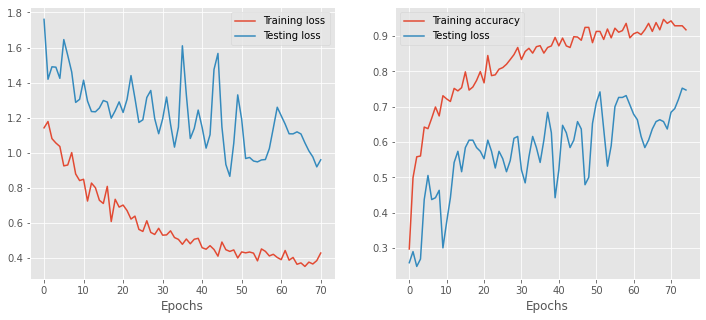

In [105]:
plt.style.use("ggplot")
fig, ax = plt.subplots(1,2, figsize=(12, 5))

#Starting from the 4th epochs to have a better visualisation of the decreasing loss
ax[0].plot(hist.history["loss"][4:], label="Training loss")
ax[0].plot(hist.history["val_loss"][4:], label="Testing loss")
ax[0].set_xlabel("Epochs") ; ax[0].legend()

ax[1].plot(hist.history["accuracy"], label="Training accuracy")
ax[1].plot(hist.history["val_accuracy"], label="Testing loss")
ax[1].set_xlabel("Epochs") ; ax[1].legend()

plt.show()

In [106]:
num_model = round(np.mean(model.evaluate(X_test, y_test)[-1]),3)

6/6 [==============================] - 0s 56ms/step - loss: 0.9608 - accuracy: 0.7474


In [107]:
model.save(f'PSG_face_recognition{IMG_DIMS[0]}_{str(num_model)[2:]}.h5')

# Test the model 

In [2]:
from tensorflow import keras
model = keras.models.load_model('./PSG_face_recognition64_747.h5')

In [68]:
IMG_DIMS = (64, 64, 3)
LR = 0.001
EPOCHS = 75
BATCHSIZE = 128


In [102]:
def test_image(path):
    a = cv2.imread(path)
    a = cv2.resize(a, IMG_DIMS[:2])
    plt.imshow(a)
    plt.show()
    a=img_to_array(a)
    a = np.array(a, dtype="float")
    a /= 255.0
    a=a.reshape(-1,64, 64, 3)
    predictions=model.predict(a)
    players = ('Marquinhos','Mbappe','Navas','Neymar','Verratti')
    print("The predicted character on the image is "+str(players[np.argmax(predictions[0])])+"\n \n \n \n")


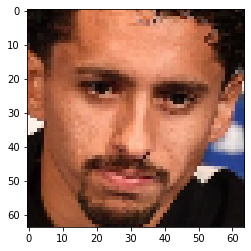

The predicted character on the image is Marquinhos
 
 
 



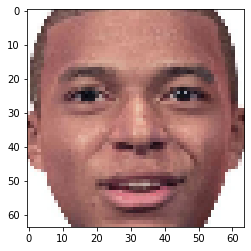

The predicted character on the image is Mbappe
 
 
 



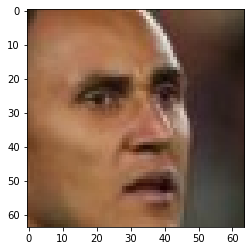

The predicted character on the image is Navas
 
 
 



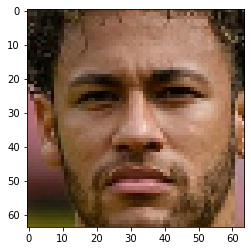

The predicted character on the image is Neymar
 
 
 



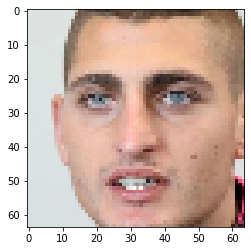

The predicted character on the image is Verratti
 
 
 



In [103]:
players = ('Marquinhos','Mbappe','Navas','Neymar','Verratti')
for player in players:
    
    test_image("./faces/"+str(player)+"/0.jpg")

# We tested the very good accuracy of our model and confirmed that these predictions are accurate 